# Training CNN for image recognition - SVHN dataset

In this Colab notebook I try to implement a Convolutional Neural Network in order to classify the digits in house numbers plates from photos, training various models on the SVHN dataset. State of the art networks can nowadays obtain an accuracy of $\approx$ 99% on this dataset.

We shall start by importing all the stuff we need

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


Checking the GPU

In [ ]:
torch.randn(5).cuda()

tensor([-0.3220,  0.2729,  1.4896, -0.8702, -0.5996], device='cuda:0')

Let's define a ResNet

In [ ]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        nn.init.kaiming_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(intermediate_channels)
        self.elu = nn.ELU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        
        x = self.bn1(x)
        x = self.elu(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = self.elu(x)
        x = self.conv2(x)

        x = self.bn3(x)
        x = self.conv3(x)


        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.elu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.bn1 = nn.BatchNorm2d(image_channels)
        self.elu = nn.ELU()
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(
        block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
        block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
        block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
        block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []


        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
            nn.Conv2d(
            self.in_channels,
            intermediate_channels * 4,
            kernel_size=1,
            stride=stride,
            bias=False
            ),
            nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
        block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

    
        return nn.Sequential(*layers)


Now let's define our model, load the dataset and define loss and optimizer

In [ ]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [ ]:
train_data = datasets.SVHN('data', 'train', download = True, transform = transforms.ToTensor())
train_data_vis = datasets.SVHN('data', 'train', download = True)
test_data = datasets.SVHN('data', 'test', download = True, transform = transforms.ToTensor())
test_data_vis = datasets.SVHN('data', 'test', download = True)
train, val = random_split(train_data, (len(train_data)-5000,5000))
train_loader = DataLoader(train, batch_size = 32, drop_last = True)
test_loader = DataLoader(test_data, batch_size = 1)
val_loader = DataLoader(val, batch_size = 512)


Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


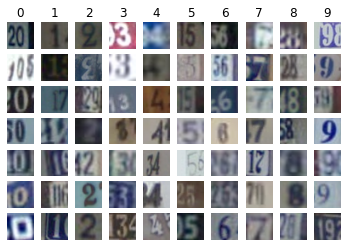

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7

X_train = []
y_train = np.zeros((len(train_data_vis),))

for i, x in enumerate(train_data_vis):
  X_train.append(x[0])
  y_train[i] = x[1]

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
model = ResNet50(3, 11).cuda()

In [ ]:
params = list(model.parameters())
optimiser = optim.SGD(params, lr = i, momentum = 0.9, weight_decay=0)

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
def add_noise(m, scale = 1e-4):
    with torch.no_grad():
        for param in m.parameters():
            param.add_(torch.randn(param.size()).cuda() * scale)


Finally, the network is set and ready for training and evaluation

In [ ]:
best_model = None
num_epochs = 20
acc_tot = list()
acc_tot.append(0)
acc_hist = []
loss_hist = []
model.apply(weight_reset)

for q in range(num_epochs):
        model.train()
        losses1 = list()
        losses2 = list()
        tr_acc = 0
        val_acc = 0
        val_tot = 0
        for x, y in train_loader:

            b = x.size(0)
            x = x.cuda()
            l = model(x)
            _, predicted = torch.max(l.data.cpu(), 1)
            J = loss(l, y.cuda())
            model.zero_grad()
            J.backward()
            optimiser.step()
            losses1.append(J.item())
            tr_acc += (predicted == y).float().sum()
            acc_hist.append(tr_acc)
            loss_hist.append(J.item())

        acc = tr_acc / (len(train_data)-5000)
        print( 'Epoch ' + str(q+1) + ' - Train loss: ' + str(torch.tensor(losses1).mean().numpy()))
        print('Accuracy: '+str(acc.numpy()))
        model.eval()
        for x, y in val_loader:
            b = x.size(0)
            x = x.cuda()
            with torch.no_grad():
                l = model(x)
            _, predicted = torch.max(l.data.cpu(), 1)
            J = loss(l, y.cuda())
            losses2.append(J.item())
            val_acc += (predicted == y).float().sum()
            val_tot += predicted.size(0)
        
        acc = val_acc / 5000
        if acc > max(acc_tot):
            best_model = model
        acc_tot.append(acc.item())
        print('Val loss: ' + str(torch.tensor(losses2).mean().numpy()))
        print('Accuracy: '+str(acc.numpy()))
        model.apply(add_noise)  
        

Running with learning rate at 1e-05


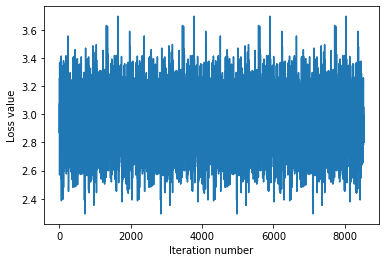

In [ ]:
plt.plot(loss_hist) 
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Those aren't bad results at all... To get a sense of what's happening, let's have a look at the test set, to check our accuracy and confusion matrix and see what might be improved

In [ ]:
losses2 = list()
test_acc=0
y_pred = np.array(0,)
y_act = np.array(0,)
X_test = []
for i, x in enumerate(test_data_vis):
  X_test.append(x[0])
for x, y in test_loader:
    best_model.eval()
    b = x.size(0)
    x = x.cuda()
    with torch.no_grad():
        l = best_model(x)
    _, predicted = torch.max(l.data.cpu(), 1)
    J = loss(l, y.cuda())
    losses2.append(J.item())
    y_act = np.append(y_act, y.item())
    y_pred= np.append(y_pred, predicted.item())
    test_acc += (predicted == y).float().sum()

acc = test_acc / len(test_data)
print('Test loss: ' + str(torch.tensor(losses2).mean().numpy()))
print('Accuracy: '+str(acc.numpy()))


Test loss: 2.9614296
Accuracy: 0.08116933


(10, 10)


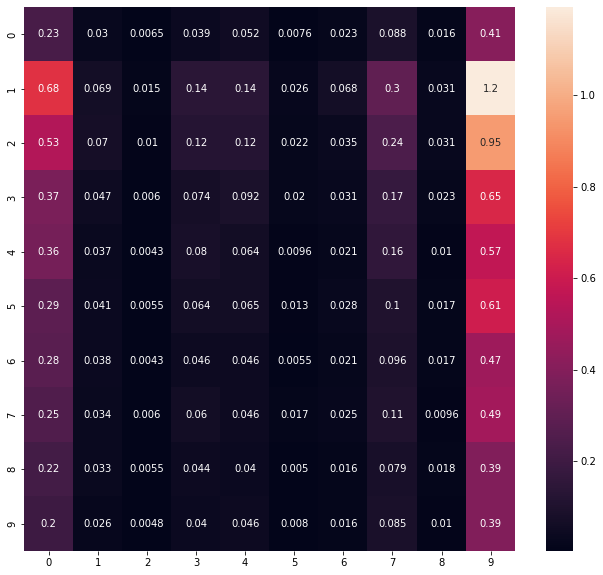

<Figure size 432x288 with 0 Axes>

In [ ]:
# Build confusion matrix
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
cf_matrix = confusion_matrix(y_act, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis = 1), index = [i for i in classes],
                     columns = [i for i in classes])
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sn.heatmap(df_cm, annot=True, ax = ax)
plt.show()
plt.savefig('output.png')
examples_per_class = 8
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_act != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx-1])
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()